In [1]:
import sys
sys.path.append('..')
from network_rt_simulation import NetworkSimulator
from matplotlib import pyplot as plt
from scipy import stats
#from statsmodels.graphics.gofplots import qqplot_2samples 
import numpy as np
from plotting_utils import plot_rt_distribution, display_1D_dyn

### Define the parameters for the DDM and neural circuit model, find the optimal $c_1$ that minimizes the error

In [2]:
# Load saved RT data
DDM_params = {
    'v': .5,
    'sig_W': .5,
    'boundary': .7,
    'dt':1.,
    'dt_DDM': 25.
}

CANN_params = {
    'dur1': 500,
    'dur2': 5500,
    'edge_type': 'tanh', 
    'num': 1024,
    'tau_bump': 0.08,
    'tau_edge': 4,
    'beta': 2,
    'sigma_edge': 2,
    'offset': 3.85,
    'delta_z': 1/40,
    'J0_bump': 4,
    'J0_edge': 1,
    'a': 0.25,
    'A': 10,
    'c2': 1
}
CANN_params.update({'c1': 2.563})
c1_range = np.linspace(0.1, 4, 20)
mon_vars = ['s_pos', 'clicks_left', 'clicks_right']
Simulator = NetworkSimulator(DDM_params, CANN_params, mon_vars=mon_vars, save_runner=True, c1_range=c1_range)
#c1_opt, err_per_c1 = Simulator.find_optimal_c1(c1_range, num_seeds=20)
#np.savez_compressed('c1_opt.npz', c1_opt=c1_opt, err_per_c1=err_per_c1)

In [3]:
res = np.load('c1_opt.npz')
c1_opt, err_per_c1 = res['c1_opt'], res['err_per_c1']

seed_start = 0
CANN_params.update({'c1': c1_opt})
boundary = DDM_params['boundary']
mon_vars = ['u', 's', 's_pos', 'u_pos', 'clicks_left', 'clicks_right']
Simulator = NetworkSimulator(DDM_params, CANN_params, mon_vars=mon_vars, save_runner=True)
Simulator.simulate_network(num_trials=20, batch_size=20, seed_mode='fixed', seed_start=seed_start)



Starting simulation with 20 trials in 1 batches of size 20
Memory threshold set to: 8000 MiB

Processing Batch 1/1 (Trials 1-20)
--------------------------------------------------


Trials in batch 1: 100%|████████████████████████| 20/20 [01:14<00:00,  3.74s/it]



Batch 1 completed:
Correct responses: 18
Incorrect responses: 2
CPU Memory after batch 1: 1941.29 MiB
--------------------------------------------------

Simulation completed!
Total correct responses: 18
Total incorrect responses: 2
Final CPU Memory Usage: 1941.29 MiB


([2589.0,
  2577.0,
  1930.0,
  2637.0,
  1834.0,
  1595.0,
  2634.0,
  1488.0,
  1590.0,
  2842.0,
  3232.0,
  2438.0,
  4270.0,
  2586.0,
  2034.0,
  2341.0,
  1538.0,
  1943.0],
 [3003.0, 1692.0])

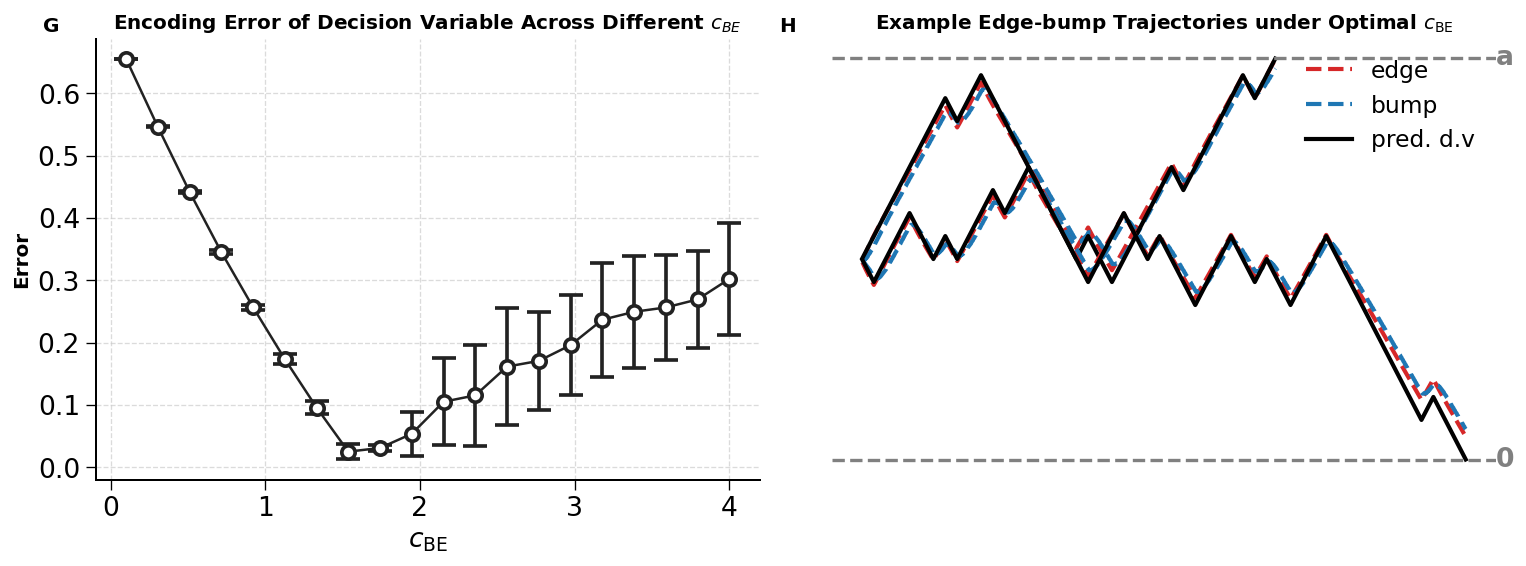

: 

In [21]:

# 神经科学常用配色
color_errorbar = '#222222'  # 深灰黑
# 新配色
color_edge = '#D62728'   # 红色 (matplotlib经典红)
color_bump = '#1F77B4'   # 蓝色 (matplotlib经典蓝)
color_xpred = '#000000'  # 黑色

plt.rcParams.update({
    'font.size': 16,
    'axes.labelweight': 'bold',
    'axes.titlesize': 18,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.2,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'legend.frameon': False,
    'legend.fontsize': 14,
    'figure.dpi': 120,
})

res = np.load('c1_opt.npz')
c1_opt, err_per_c1 = res['c1_opt'], res['err_per_c1']

def remove_outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower = q1 - 1 * iqr
    upper = q3 + 1 * iqr
    return data[(data >= lower) & (data <= upper)]

filtered_err_per_c1 = []
for errs in err_per_c1:
    filtered = remove_outliers_iqr(errs)
    filtered_err_per_c1.append(filtered)
mean_err = np.array([np.mean(errs) for errs in filtered_err_per_c1])
std_err = np.array([np.std(errs) for errs in filtered_err_per_c1])

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# --- 子图1：Errorbar ---
axes[0].errorbar(
    c1_range, mean_err, yerr=std_err,
    fmt='o-', color=color_errorbar, ecolor=color_errorbar,
    elinewidth=2.2, capsize=7, capthick=2.2, markersize=8, markerfacecolor='white', markeredgewidth=2.2
)
axes[0].set_xlabel(r'$c_{\text{BE}}$')
axes[0].set_ylabel(r'Error', fontsize=12)
axes[0].set_title(r'Encoding Error of Decision Variable Across Different $c_{BE}$', fontsize=12, fontweight='bold')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].grid(True, linestyle='--', linewidth=0.8, color='#cccccc', alpha=0.7)
axes[0].text(-0.08, 1.05, 'G', transform=axes[0].transAxes, fontsize=12, fontweight='bold', va='top', ha='left')

# --- 子图2：轨迹 ---
exp_seed = [2, 15]
c1_exp = c1_opt
boundary = DDM_params['boundary']
mon_vars = ['u', 's', 's_pos', 'u_pos', 'clicks_left', 'clicks_right']


t_prep = int(CANN_params['dur1'] + CANN_params['dur2'] * 0.1)
dx = Simulator.dx

for seed in exp_seed:
    clicks_left = Simulator.runners_log[seed].mon.clicks_left[t_prep:]
    clicks_right = Simulator.runners_log[seed].mon.clicks_right[t_prep:]
    dt_DDM = DDM_params['dt_DDM']
    x_pred = np.cumsum(clicks_left * (-dx) / dt_DDM  + clicks_right * dx / dt_DDM)
    s_pos = Simulator.runners_log[seed].mon.s_pos[t_prep:]
    u_pos = Simulator.runners_log[seed].mon.u_pos[t_prep:]
    cross_idx = np.where(np.abs(x_pred) > boundary)[0]
    hit_idx = cross_idx[0] if cross_idx.size > 0 else -1    
    if seed == 2:
        axes[1].plot(s_pos[:hit_idx], label='edge', color=color_edge, linewidth=2.5, linestyle='--')
        axes[1].plot(u_pos[:hit_idx], label='bump', color=color_bump, linewidth=2.5, linestyle='--')
        axes[1].plot(x_pred[:hit_idx], label='pred. d.v', color=color_xpred, linewidth=2.5, linestyle='-')
    else:
        axes[1].plot(s_pos[:hit_idx],  color=color_edge, linewidth=2.5, linestyle='--')
        axes[1].plot(u_pos[:hit_idx],  color=color_bump, linewidth=2.5, linestyle='--')
        axes[1].plot(x_pred[:hit_idx], color=color_xpred, linewidth=2.5, linestyle='-')  

# 去掉右侧子图的所有坐标轴、刻度、边框
axes[1].legend(loc='upper right', frameon=False)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_title(r'Example Edge-bump Trajectories under Optimal $c_{\text{BE}}$', fontsize=12)  # 可选：去掉标题
# 画两条水平直线表示boundary
axes[1].axhline(boundary, color='gray', linestyle='--', linewidth=2, alpha=1)
axes[1].axhline(-boundary, color='gray', linestyle='--', linewidth=2, alpha=1)
# 标注 boundary value
xlim = axes[1].get_xlim()
axes[1].text(xlim[1], boundary, 'a', va='center', ha='left', fontsize=16, fontweight='bold', color='gray')
axes[1].text(xlim[1], -boundary, '0', va='center', ha='left', fontsize=16, fontweight='bold', color='gray')
axes[1].text(-0.08, 1.05, 'H', transform=axes[1].transAxes, fontsize=12, fontweight='bold', va='top', ha='left')
plt.tight_layout()
plt.show()

### find the optimal c_1 for different drift rate 



In [3]:
v_range = np.linspace(0.1, 1.5, 10)
c_range = np.linspace(0.1, 4, 20)
c1_opt_per_v = []
for v in v_range:
    DDM_params.update({'v': v})
    Simulator = NetworkSimulator(DDM_params, CANN_params, mon_vars=mon_vars, save_runner=True, c1_range=c1_range)
    c1_opt, err_per_c1 = Simulator.find_optimal_c1(c1_range, num_seeds=10)
    c1_opt_per_v.append(c1_opt)


100%|██████████| 20/20 [00:28<00:00,  1.40s/it]
